In [62]:
! pip install openai


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [63]:
! pip install pandas matplotlib seaborn


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [90]:
# Set your OpenAI API key
openai.api_key = 'xxx'
os.environ["OPENAI_API_KEY"] = 'xxxx'

In [65]:
import openai
import asyncio
import pandas as pd
import os, json
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# Set your OpenAI API key
# openai.api_key = os.getenv("OPENAI_API_KEY")

async def analyze_text(text):
    prompt = f"""Analyze the following text and provide:
    1. Sentiment score (from -1 to 1, where -1 is very negative, 0 is neutral, and 1 is very positive)
    2. Main topic (a single word in lowercase)
    3. Sub-topic (one or two words in lowercase, more specific than the main topic)

    Text: {text}

    Respond in JSON format with keys 'sentiment', 'main_topic', and 'sub_topic'.
    Ensure all topics are in lowercase.
    If a sub-topic cannot be determined, use "general" as the sub-topic.

    Example response:
    {{"sentiment": 0.5, "main_topic": "github", "sub_topic": "new feature"}}
    """
    try:
        response = await openai.ChatCompletion.acreate(
            model="gpt-3.5-turbo",  # Ensure correct model
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return json.loads(response.choices[0].message["content"])
    
    except json.JSONDecodeError as e:
        print(f"JSON decode error: {e}")
        return {"sentiment": None, "main_topic": "unknown", "sub_topic": "general"}
    
    except Exception as e:
        print(f"Error during API request: {e}")
        return {"sentiment": None, "main_topic": "unknown", "sub_topic": "general"}

async def process_batch(texts, semaphore):
    async def process_text(text):
        async with semaphore:
            return await analyze_text(text)
    
    tasks = [asyncio.create_task(process_text(text)) for text in texts]
    return await asyncio.gather(*tasks)


In [66]:
# Load Hacker News data
column_names = ['id', 'type', 'author', 'created_at', 'title', 'text', 'url', 'score', 'parent']
hn_data = pd.read_csv('/Users/raj/Desktop/downloaded_data_dbt/hacker_news/hacker_news_data.csv',header=None, names=column_names)

In [67]:
hn_data.head()

,id,type,author,created_at,title,text,url,score,parent
0,41225182,comment,by,2024-08-12 14:58:52 UTC,NaN,"Neovim. You can use Lua, but you can also use ...",NaN,NaN,41224472.0
1,41220277,comment,by,2024-08-12 00:40:02 UTC,NaN,There&#x27;s also this which you can run on a ...,NaN,NaN,41218811.0
2,41220377,comment,by,2024-08-12 01:05:05 UTC,NaN,Don’t think this really fits in with HN guidel...,NaN,NaN,41219544.0
3,41225843,comment,by,2024-08-12 15:52:12 UTC,NaN,Clicking &quot;New database&quot; doesn&#x27;t...,NaN,NaN,41224286.0
4,41226964,comment,by,2024-08-12 17:20:46 UTC,NaN,I&#x27;ll echo others&#x27; comments that you ...,NaN,NaN,41224472.0


In [68]:
# Data cleaning
hn_data['parent'] = pd.to_numeric(hn_data['parent'], errors='coerce').astype('Int64')
hn_data['score'] = pd.to_numeric(hn_data['score'], errors='coerce').astype('Int64')
hn_data['url'] = hn_data['url'].fillna('')
hn_data['title'] = hn_data['url'].fillna('')

# Display info about the dataset
print(hn_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648 entries, 0 to 1647
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1648 non-null   int64 
 1   type        1648 non-null   object
 2   author      1648 non-null   object
 3   created_at  1648 non-null   object
 4   title       1648 non-null   object
 5   text        1313 non-null   object
 6   url         1648 non-null   object
 7   score       443 non-null    Int64 
 8   parent      1205 non-null   Int64 
dtypes: Int64(2), int64(1), object(6)
memory usage: 119.2+ KB
None


In [69]:
# Display the first few rows to verify the data
print(hn_data.head())

         id     type author               created_at title  \
0  41225182  comment     by  2024-08-12 14:58:52 UTC         
1  41220277  comment     by  2024-08-12 00:40:02 UTC         
2  41220377  comment     by  2024-08-12 01:05:05 UTC         
3  41225843  comment     by  2024-08-12 15:52:12 UTC         
4  41226964  comment     by  2024-08-12 17:20:46 UTC         

                                                text url  score    parent  
0  Neovim. You can use Lua, but you can also use ...       <NA>  41224472  
1  There&#x27;s also this which you can run on a ...       <NA>  41218811  
2  Don’t think this really fits in with HN guidel...       <NA>  41219544  
3  Clicking &quot;New database&quot; doesn&#x27;t...       <NA>  41224286  
4  I&#x27;ll echo others&#x27; comments that you ...       <NA>  41224472  


In [70]:
 # Combine title and text for analysis, handling NaN values
hn_data['full_text'] = hn_data['title'].fillna('') + ' ' + hn_data['text'].fillna('')

In [71]:
# Set up semaphore for rate limiting
semaphore = asyncio.Semaphore(10)  # Adjust this value based on your API rate limits

# Define batch size
batch_size = 50

# Initialize an empty list to store all results
all_results = []

# Loop through the data in batches
for i in range(0, len(hn_data), batch_size):
    # Get the current batch
    batch = hn_data['full_text'][i:i + batch_size].tolist()
    
    # Process the batch
    batch_results = await process_batch(batch, semaphore)
    
    # Collect the results
    all_results.extend([{
        'id': hn_data.iloc[i + j]['id'],
        'sentiment': result['sentiment'],
        'main_topic': result['main_topic'],
        'sub_topic': result['sub_topic']
    } for j, result in enumerate(batch_results)])
    
    # Print progress
    print(f"Processed {min(i + batch_size, len(hn_data))} out of {len(hn_data)} entries")

Processed 50 out of 1648 entries
Processed 100 out of 1648 entries
Processed 150 out of 1648 entries
Processed 200 out of 1648 entries
Processed 250 out of 1648 entries
Processed 300 out of 1648 entries
Processed 350 out of 1648 entries
Processed 400 out of 1648 entries
Processed 450 out of 1648 entries
Processed 500 out of 1648 entries
Processed 550 out of 1648 entries
Processed 600 out of 1648 entries
Processed 650 out of 1648 entries
Processed 700 out of 1648 entries
Processed 750 out of 1648 entries
Processed 800 out of 1648 entries
Processed 850 out of 1648 entries
Processed 900 out of 1648 entries
Processed 950 out of 1648 entries
Processed 1000 out of 1648 entries
Processed 1050 out of 1648 entries
Processed 1100 out of 1648 entries
Processed 1150 out of 1648 entries
Processed 1200 out of 1648 entries
Processed 1250 out of 1648 entries
Processed 1300 out of 1648 entries
Processed 1350 out of 1648 entries
Processed 1400 out of 1648 entries
Processed 1450 out of 1648 entries
Proce

In [75]:
# Create DataFrame from results
results_df = pd.DataFrame(all_results)
results_df.head()

,id,sentiment,main_topic,sub_topic
0,41225182,0.5,neovim,customization
1,41220277,0.0,raspberry pi,general
2,41220377,-0.5,guidelines,general
3,41225843,-0.6,ui,functionality
4,41226964,0.6,neovim,lua vs python


In [76]:
# Save results
results_df.to_csv('/Users/raj/Desktop/downloaded_data_dbt/hacker_news/hn_sentiment_topics.csv', index=False)

# Analyze topics
main_topic_counts = Counter(results_df['main_topic'])
sub_topic_counts = Counter(results_df['sub_topic'])
top_main_topics = dict(main_topic_counts.most_common(10))
top_sub_topics = dict(sub_topic_counts.most_common(10))

In [84]:
# Analyze sentiment
results_df['sentiment'] = pd.to_numeric(results_df['sentiment'], errors='coerce')
sentiment_distribution = results_df['sentiment'].value_counts(normalize=True, bins=[-1, -0.5, 0, 0.5, 1]) * 100

# Visualizations
plt.figure(figsize=(15, 15))

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

Text(0, 0.5, 'Count')

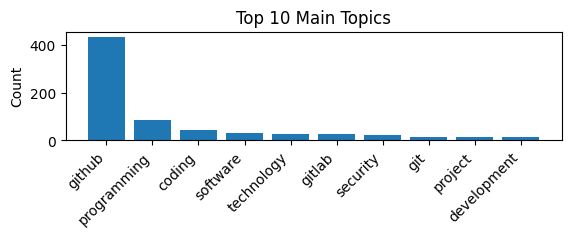

In [85]:
# Top 10 Main Topics
plt.subplot(3, 1, 1)
plt.bar(top_main_topics.keys(), top_main_topics.values())
plt.title('Top 10 Main Topics')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

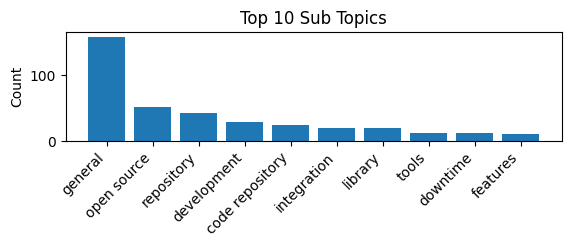

In [86]:
# Top 10 Sub Topics
plt.subplot(3, 1, 2)
plt.bar(top_sub_topics.keys(), top_sub_topics.values())
plt.title('Top 10 Sub Topics')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')

In [89]:
# Sentiment Distribution
plt.subplot(3, 1, 3)
sns.histplot(results_df['sentiment'], kde=True, bins=20)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('/Users/raj/Desktop/downloaded_data_dbt/hacker_news/hn_analysis_results.png')
plt.close()

In [88]:
# Print summary
print("\nTop 10 Main Topics:")
for topic, count in top_main_topics.items():
    print(f"{topic}: {count}")

print("\nTop 10 Sub Topics:")
for topic, count in top_sub_topics.items():
    print(f"{topic}: {count}")

print("\nSentiment Distribution:")
print(sentiment_distribution)

print("\nAnalysis complete. Results saved to 'hn_sentiment_topics.csv' and visualizations saved to 'hn_analysis_results.png'.")



Top 10 Main Topics:
github: 434
programming: 85
coding: 45
software: 33
technology: 28
gitlab: 28
security: 21
git: 16
project: 15
development: 14

Top 10 Sub Topics:
general: 158
open source: 52
repository: 43
development: 29
code repository: 24
integration: 19
library: 19
tools: 12
downtime: 12
features: 11

Sentiment Distribution:
(0.0, 0.5]        35.558252
(0.5, 1.0]        32.706311
(-0.5, 0.0]       22.087379
(-1.001, -0.5]     9.648058
Name: proportion, dtype: float64

Analysis complete. Results saved to 'hn_sentiment_topics.csv' and visualizations saved to 'hn_analysis_results.png'.
